# Pseudo-Sitemapper

#### Algorithm
1. First create a new node in the Digraph which is the root node with base_url and set traverse=False as node property
    2. Check all leaf nodes in the Digraph with traverse=False flag and set them as "current_url" list
    3. Iterate over the current_url list and scrape the child urls
    4. Create a (source, destination) tuple with (current_url, child_url)
    5. Add nodes and paths to graph
    6. Mark the current urls traversed with a node flag traversed=True
6. Repeat Steps 2-5 until until condition 2 returns empty set or N input iterations are done.

In [1]:
import time
import requests
import numpy as np
import networkx as nx
from lxml import html
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [9]:
class sitemap():
    
    """
    Algorithm:
    1. First create a new node in the Digraph which is the root node with base_url and set node properties
       2 Check all leaf nodes in the Digraph with traverse=False flag and set them as "current_url" list
       3 Iterate over the current_url list and scrape the child urls
       4 Create a (source, destination) tuple with (current_url, child_url)
       5 Add nodes and paths to graph
       6 Mark the current urls traversed with a node flag traversed=True
    7. Repeat Steps 2-6 until until condition 2 returns empty set or N input iterations are done.
    """
    
    def __init__(self, base_url, draw=False):
        self.base_url = base_url
        self.draw = draw
        self.G = nx.DiGraph()
        self.G.add_node(self.base_url, traversed=False)
        
    def draw_graph(self, g):
        cmap = {True: 'green', False: 'red'}
        pos = nx.spring_layout(self.G, k=0.5, iterations=10)
        #pos = nx.nx_pydot.pydot_layout(G, prog='dot')
        fig = plt.figure(figsize=(15,15))
        nx.draw(self.G, 
                pos=pos,
                with_labels=True, 
                node_color=[cmap[node[1].get('traversed',False)] for node in self.G.nodes(data=True)],
               )
        
    def scraper(self, current_url):
        '''
        This method can an api call to another service 
        '''
        page = requests.get(current_url)  #get response  
        tree = html.fromstring(page.content) #create tree
        tree.make_links_absolute(self.base_url)  #make relative links absolute
        
        time.sleep(2)
        return page, tree
    
    def get_links(self, tree):
        links = tree.xpath(".//a/@href")  #find hrefs
        links = [i for i in links if i.find(self.base_url)==0 and i.find('#')==-1] #filter hrefs
        return links
    
    def get_edges(self, current_url):
        page, tree = self.scraper(current_url)
        links = self.get_links(tree)
        edges = [(current_url, i) for i in links]
        
        #Set attributes
        nx.set_node_attributes(self.G, {current_url: True}, 'traversed')
        nx.set_node_attributes(self.G, {current_url: page}, 'page')
        nx.set_node_attributes(self.G, {current_url: tree}, 'tree')
        return edges
    
    def selection(self):
        return [n for n,d in self.G.nodes(data=True) if self.G.out_degree(n)==0 
                                                    and d.get('traversed',False)==False]
    
    def run_sitemapper(self, n):
        
        if self.draw==True:
            self.draw_graph(self.G)
        
        for i in tqdm(range(n), desc="Scan step"):
            leaves = self.selection()
            if len(leaves)!=0:
                
                edges = []
                for leaf in tqdm(leaves, desc="Crawl step", leave=False):
                    edges.append(self.get_edges(leaf))
                
                flat_edges = [i for j in edges for i in j]
                self.G.add_edges_from(flat_edges)
                
                if self.draw==True:
                    self.draw_graph(self.G)
                    
            else: 
                break
                
    def statistics(self):
        ordered = lambda x: list(sorted(x.items(), key=lambda item: item[1], reverse=True))
        
        d = nx.degree_centrality(self.G)
        b = nx.betweenness_centrality(self.G)
        e = nx.eigenvector_centrality(self.G)
        
        return {'degree':ordered(d), 
                'betweenness':ordered(b),
                'eigenvector':ordered(e)
               }

> Eigenvector centrality measures "influence". The influence of a node is increased if it gets connected to other influential nodes. In our case, this means pages which are centrally located in the sitemap and are tightly connected to each other as well, for example, critical pages such as frontpage, contact up, faq etc

Scan step:   0%|          | 0/3 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/1 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/17 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/6 [00:00<?, ?it/s]

[('https://moderndayfarer.com/', 0.28651619821486396),
 ('https://moderndayfarer.com/collections/frontpage', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/about-us', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/faq', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/contact-us', 0.28651619821486396),
 ('https://moderndayfarer.com/search', 0.28651619821486396),
 ('https://moderndayfarer.com/cart', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/privacy-policy', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/terms-and-conditions',
  0.28651619821486396),
 ('https://moderndayfarer.com/pages/refund-policy', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/imprint', 0.28651619821486396),
 ('https://moderndayfarer.com/pages/affiliates', 0.28651619821486396),
 ('https://moderndayfarer.com/products/dayfarer-backpack-v2',
  0.044345218014090915),
 ('https://moderndayfarer.com/products/dayfarer-active-sling',
  0.044345218014090915),

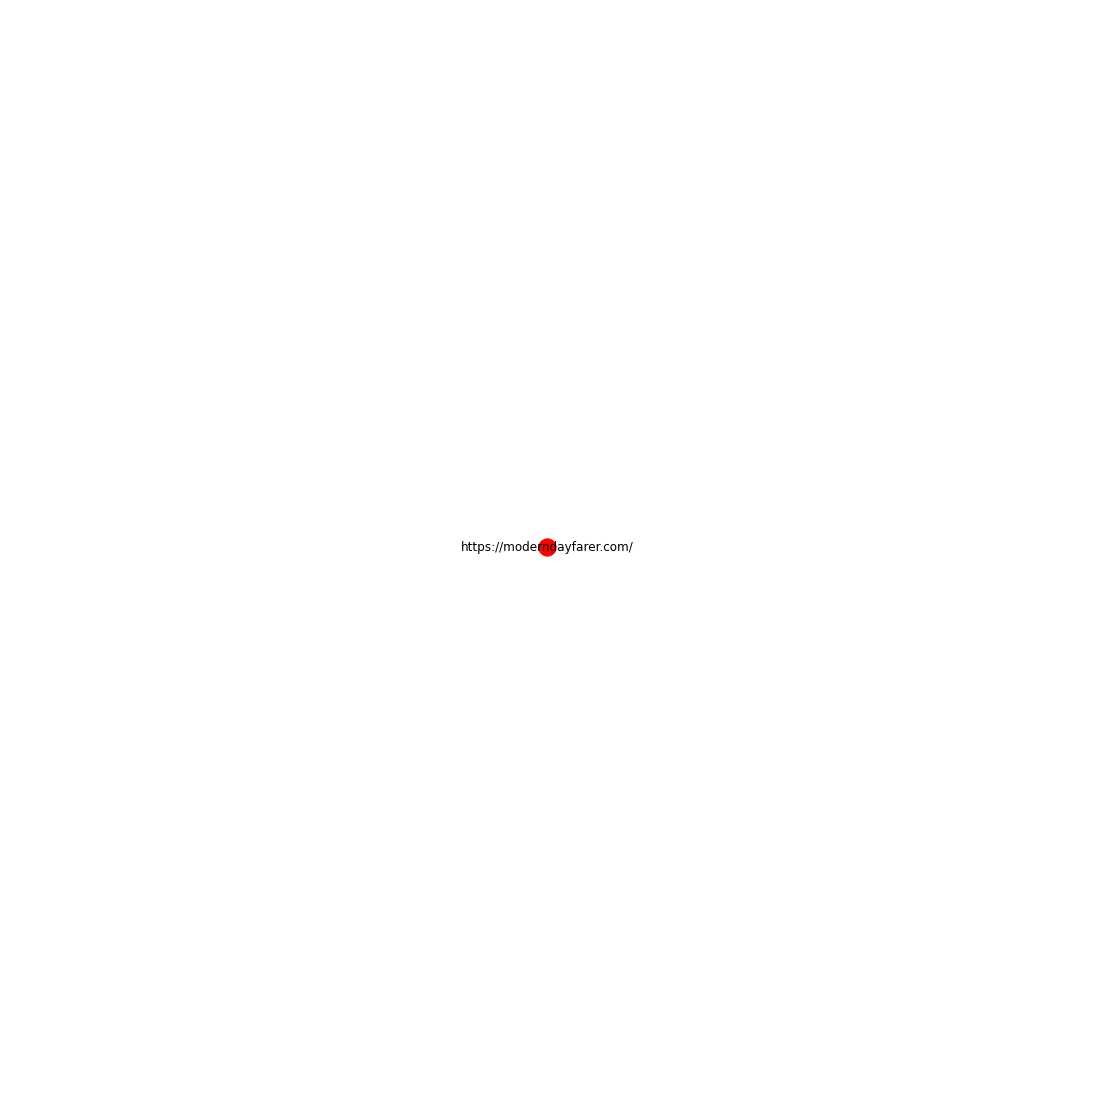

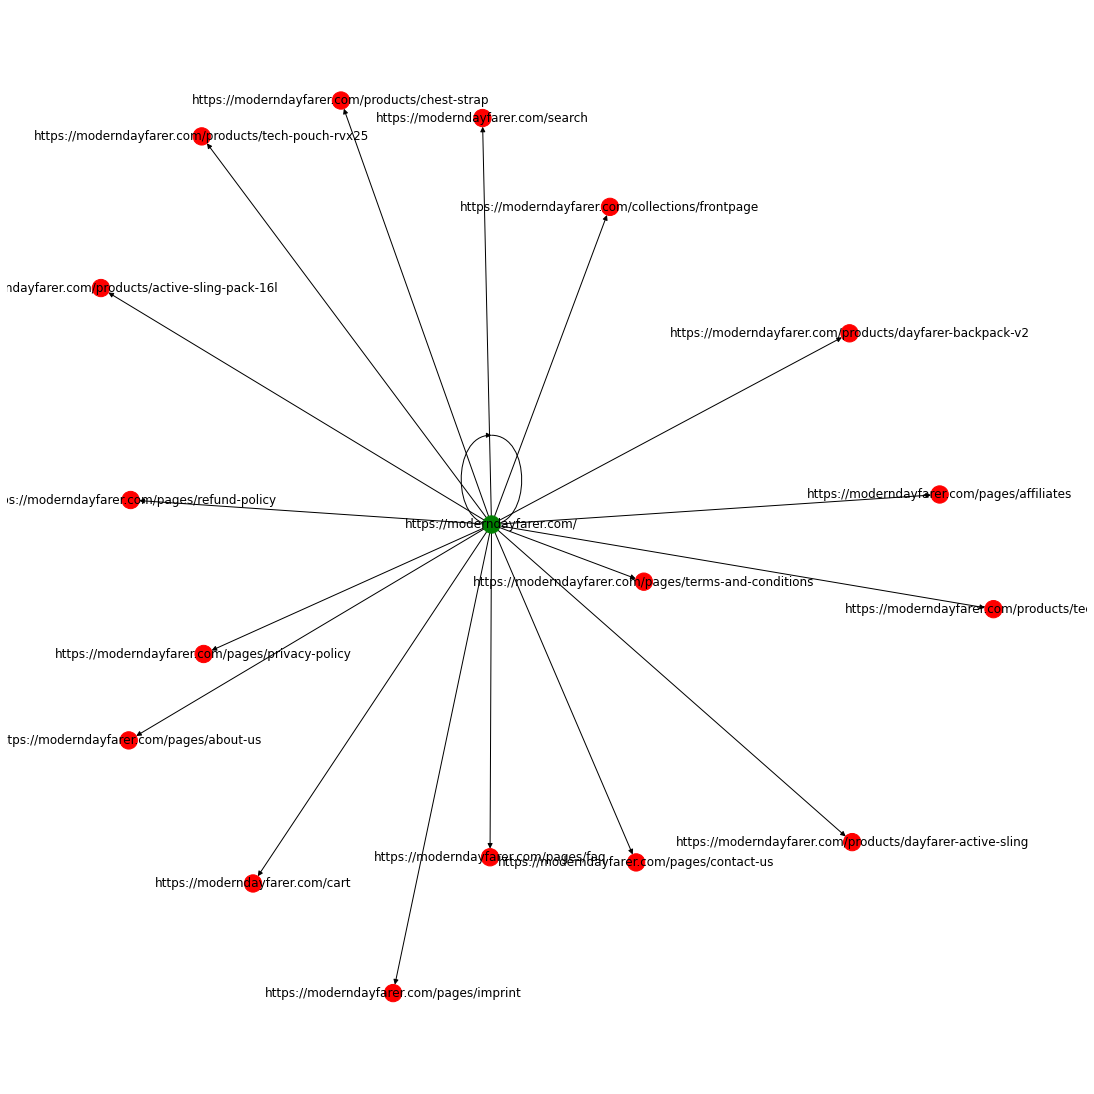

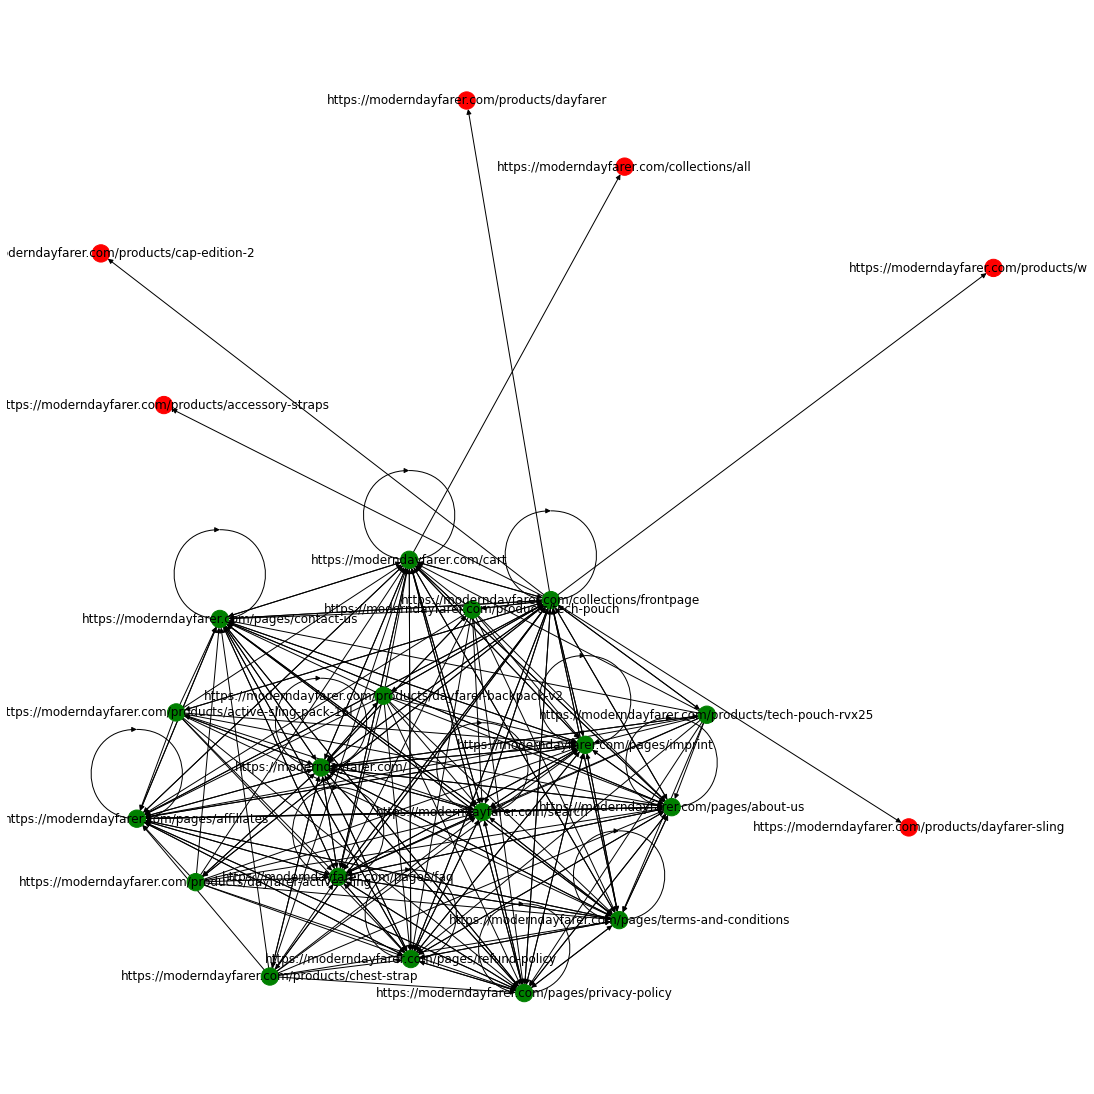

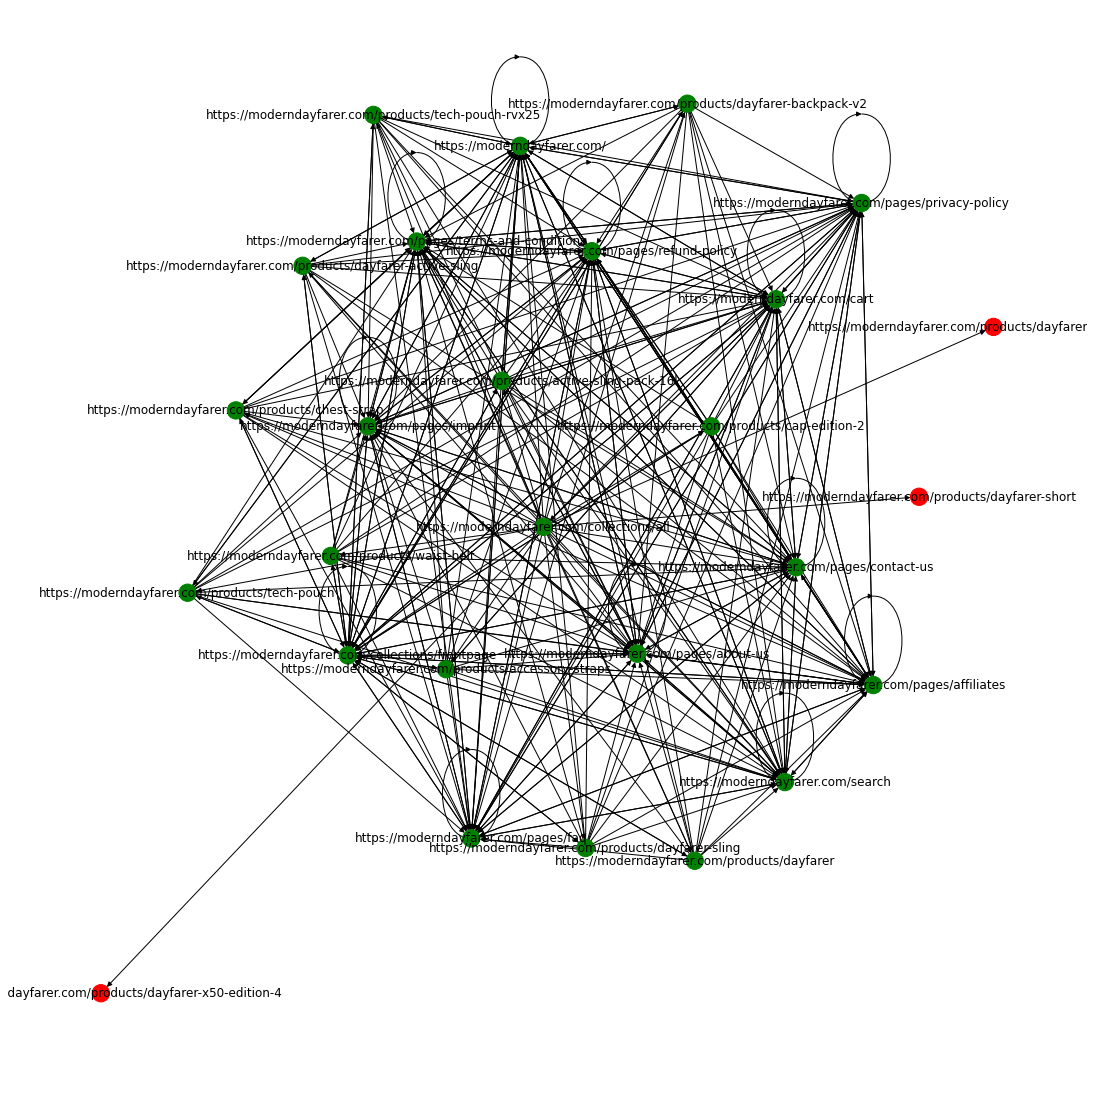

In [12]:
domain1 = sitemap('https://moderndayfarer.com/', draw=True)
domain1.run_sitemapper(3)
stats1 = domain1.statistics()
stats1['eigenvector']

Scan step:   0%|          | 0/3 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/1 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/36 [00:00<?, ?it/s]

Crawl step:   0%|          | 0/115 [00:00<?, ?it/s]

[('https://www.aersf.com/', 0.17515509496317788),
 ('https://www.aersf.com/shop-all', 0.17515509496317788),
 ('https://www.aersf.com/backpacks', 0.17515509496317788),
 ('https://www.aersf.com/slings', 0.17515509496317788),
 ('https://www.aersf.com/duffels', 0.17515509496317788),
 ('https://www.aersf.com/briefcases', 0.17515509496317788),
 ('https://www.aersf.com/totes', 0.17515509496317788),
 ('https://www.aersf.com/accessories-all', 0.17515509496317788),
 ('https://www.aersf.com/sale', 0.17515509496317788),
 ('https://www.aersf.com/all', 0.17515509496317788),
 ('https://www.aersf.com/pro-collection', 0.17515509496317788),
 ('https://www.aersf.com/travel-collection', 0.17515509496317788),
 ('https://www.aersf.com/go-collection', 0.17515509496317788),
 ('https://www.aersf.com/city-collection', 0.17515509496317788),
 ('https://www.aersf.com/active-collection', 0.17515509496317788),
 ('https://www.aersf.com/work-collection', 0.17515509496317788),
 ('https://www.aersf.com/xpac-collection',

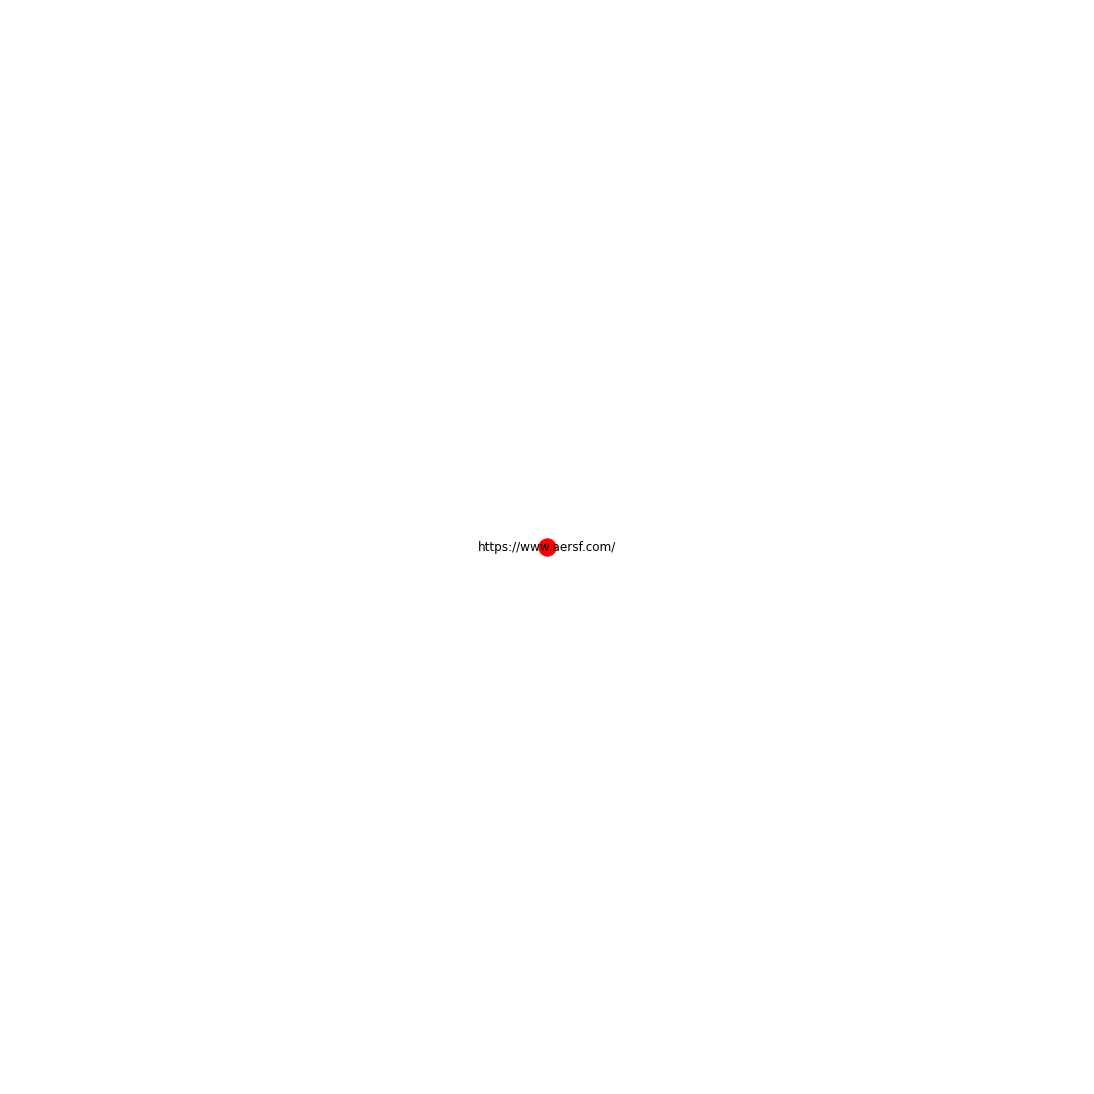

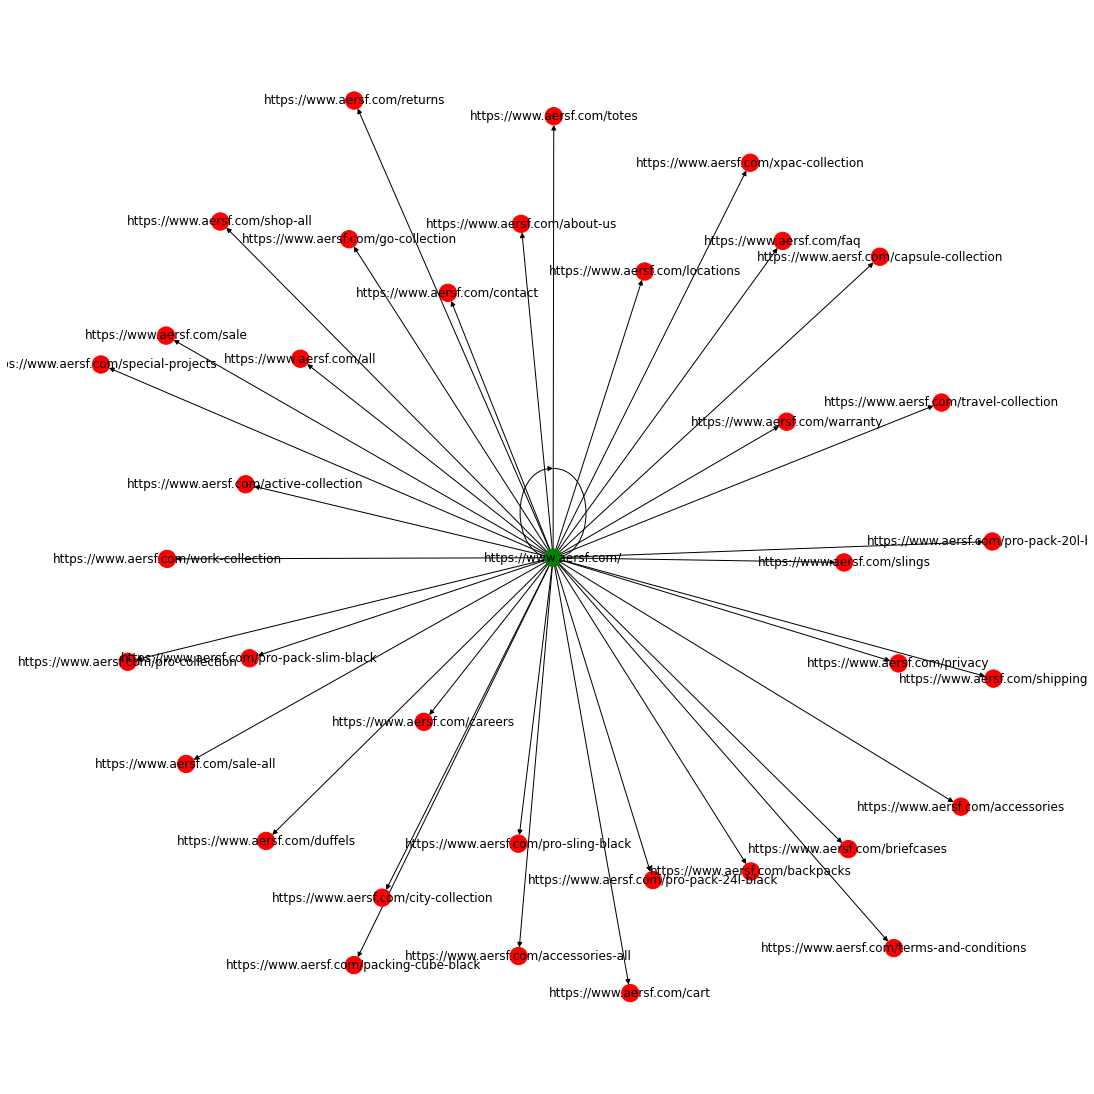

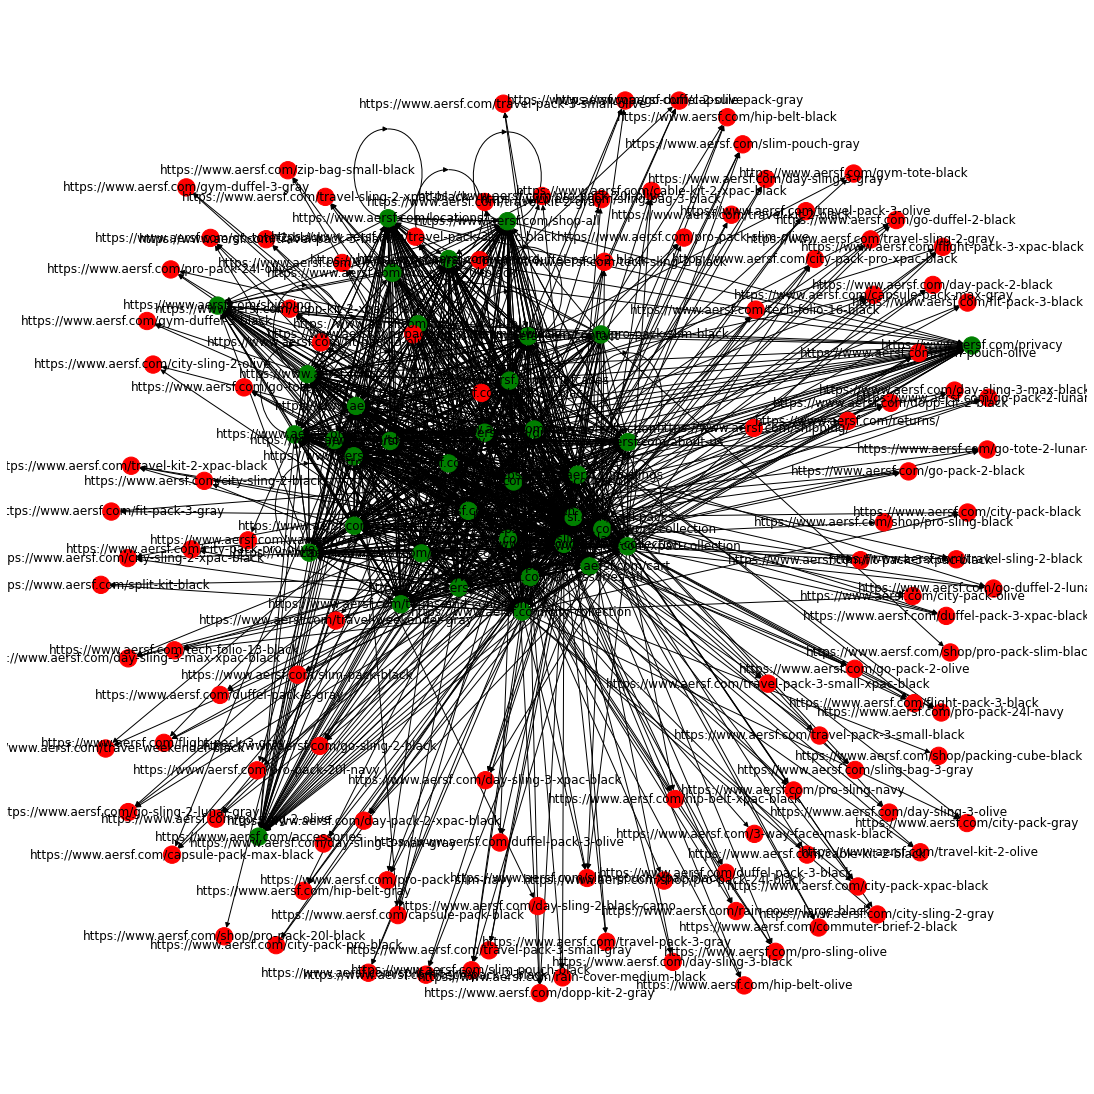

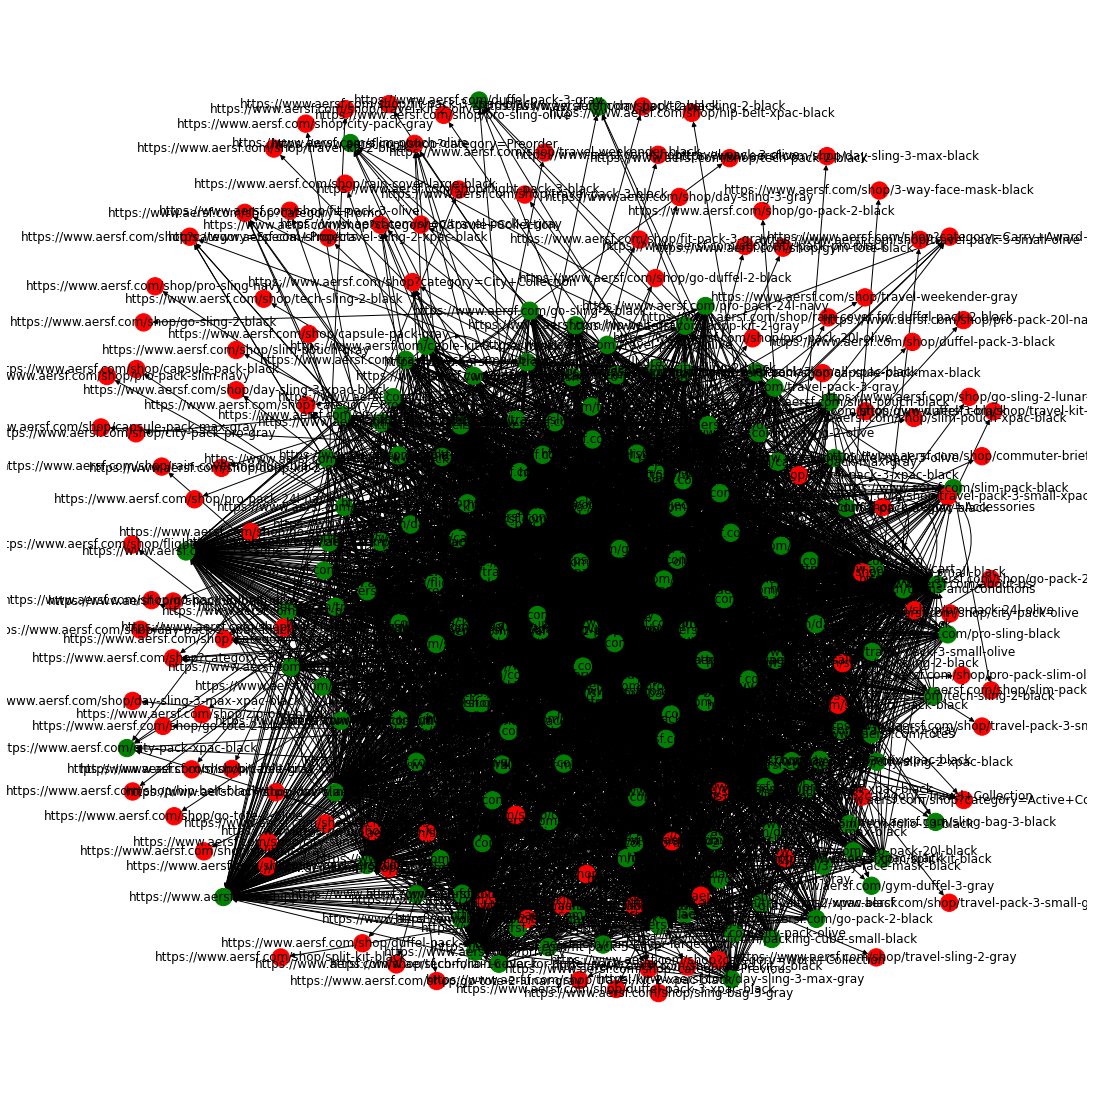

In [13]:
domain2 = sitemap('https://www.aersf.com/', draw=True)
domain2.run_sitemapper(3)
stats2 = domain2.statistics()
stats2['eigenvector']

In [41]:
# from lxml import etree

# e = list(domain1.G.nodes(data=True))[9][1]['tree']
# print(etree.tostring(e, pretty_print=True))